<a href="https://colab.research.google.com/github/parmarsuraj99/attention-experiments-keras/blob/master/MLP/Attention_FC_exp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import gc, os

import tensorflow as tf

from tensorflow.keras import models
import tensorflow.keras.backend as K
from tensorflow.keras import layers as L 
from tensorflow.keras import regularizers

import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow.keras.datasets import mnist, cifar10


In [0]:
!PYTHONHASHSEED=0

### Plotting History helper

In [0]:
def plot_hist(history):
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

### MNIST loading

In [0]:
batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

11493376/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [0]:
x_train_r = x_train.reshape(-1, x_train.shape[1]*x_train.shape[2])
x_test_r = x_test.reshape(-1, x_test.shape[1]*x_test.shape[2])

### Modelling

Don't know if this can be called attention as proposed in paper, but this does learn relation between fully connected layers. i.e., Weighting between the layers I have used this mechanism with input. But we might want to add this before classifier too.

In [0]:
gc.collect()

34

In [0]:
def get_mlp(input_shape=28*28, n_classes=10, with_attn=False):
    input_ = L.Input(shape=(input_shape, ))

    #Common head 
    x = L.Dense(input_shape, activation="relu", kernel_initializer=tf.keras.initializers.he_normal(seed=1), kernel_regularizer=tf.keras.regularizers.L1L2())(input_)
    x = L.Dense(64, activation="relu", kernel_initializer=tf.keras.initializers.he_normal(seed=1), kernel_regularizer=tf.keras.regularizers.L1L2())(x)
    x = L.Dropout(0.2)(x)
    x = L.Dense(64, activation="relu", kernel_initializer=tf.keras.initializers.he_normal(seed=1), kernel_regularizer=tf.keras.regularizers.L1L2())(x)

    if with_attn: 
        #Attention with jugaad(layer weighing)
        x = L.Dense(64, activation="relu", kernel_initializer=tf.keras.initializers.he_normal(seed=1), kernel_regularizer=tf.keras.regularizers.L1L2())(x)
        x = L.Dropout(0.2)(x)
        x = L.Dense(32, activation='tanh',kernel_initializer=tf.keras.initializers.he_normal(seed=1), kernel_regularizer=tf.keras.regularizers.L1L2())(x)   
        
        attention_probs_2 = L.Dense(32, activation='sigmoid', name='attention_probs2', kernel_initializer=tf.keras.initializers.he_normal(seed=1), kernel_regularizer=tf.keras.regularizers.L1L2())(x)
        x = L.multiply([x, attention_probs_2], name='attention_mul2')
        
        x = L.Dense(n_classes, activation="softmax", kernel_initializer=tf.keras.initializers.he_normal(seed=1), kernel_regularizer=tf.keras.regularizers.L1L2())(x)


    else:
        #No layer weighing
        x = L.Dense(64, activation="relu", kernel_initializer=tf.keras.initializers.he_normal(seed=1), kernel_regularizer=tf.keras.regularizers.L1L2())(x)
        x = L.Dropout(0.2)(x)
        
        x = L.Dense(32, activation="relu", kernel_initializer=tf.keras.initializers.he_normal(seed=1), kernel_regularizer=tf.keras.regularizers.L1L2())(x)
        x = L.Dense(32, activation='tanh',kernel_initializer=tf.keras.initializers.he_normal(seed=1), kernel_regularizer=tf.keras.regularizers.L1L2())(x)   
        x = L.Dense(n_classes, activation="softmax", kernel_initializer=tf.keras.initializers.he_normal(seed=1), kernel_regularizer=tf.keras.regularizers.L1L2())(x)
        
        
    
    model = models.Model(inputs=input_, outputs=x)
    return model


model_k = get_mlp(x_train_r.shape[1], n_classes=10, with_attn=False)
model_k.summary()


Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_62 (Dense)             (None, 784)               615440    
_________________________________________________________________
dense_63 (Dense)             (None, 64)                50240     
_________________________________________________________________
dropout_18 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_64 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_65 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_19 (Dropout)         (None, 64)                0  

### Model with layer weighing

In [0]:
model_a = get_mlp(with_attn=True)
model_a.compile("adam","categorical_crossentropy", metrics=["accuracy"])

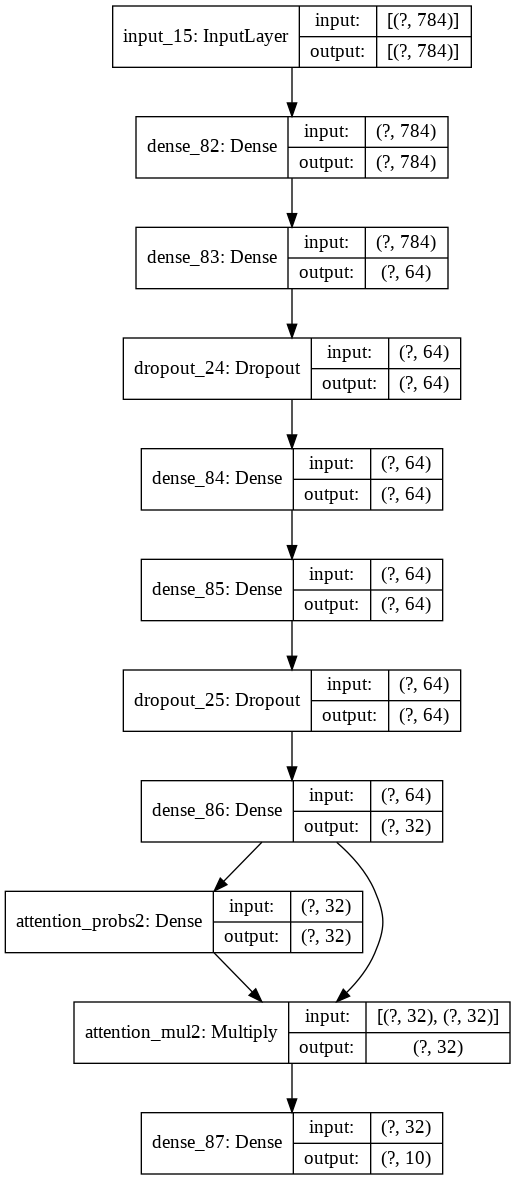

In [0]:
plot_model(model_a, show_shapes=True, expand_nested=True)

In [0]:
hist_a = model_a.fit(x_train_r, y_train, validation_data=(x_test_r, y_test), epochs=10, batch_size=2048)

Epoch 1/10
30/30 [==============================] - 4s 121ms/step - loss: 1.5442 - accuracy: 0.5907 - val_loss: 0.8021 - val_accuracy: 0.8885
Epoch 2/10
30/30 [==============================] - 3s 114ms/step - loss: 0.7486 - accuracy: 0.8763 - val_loss: 0.4058 - val_accuracy: 0.9347
Epoch 3/10
30/30 [==============================] - 3s 114ms/step - loss: 0.4107 - accuracy: 0.9312 - val_loss: 0.2538 - val_accuracy: 0.9522
Epoch 4/10
30/30 [==============================] - 3s 114ms/step - loss: 0.2689 - accuracy: 0.9501 - val_loss: 0.1900 - val_accuracy: 0.9603
Epoch 5/10
30/30 [==============================] - 3s 114ms/step - loss: 0.1981 - accuracy: 0.9618 - val_loss: 0.1572 - val_accuracy: 0.9656
Epoch 6/10
30/30 [==============================] - 3s 114ms/step - loss: 0.1539 - accuracy: 0.9695 - val_loss: 0.1327 - val_accuracy: 0.9721
Epoch 7/10
30/30 [==============================] - 3s 114ms/step - loss: 0.1242 - accuracy: 0.9754 - val_loss: 0.1159 - val_accuracy: 0.9743
Epoch 

Test loss: 0.09486394375562668
Test accuracy: 0.9776999950408936
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


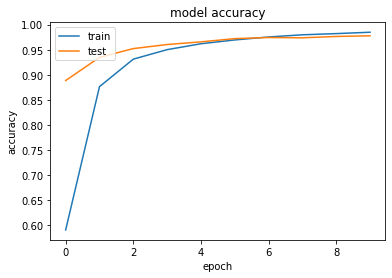

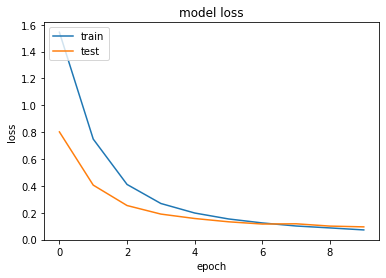

In [0]:
score = model_a.evaluate(x_test_r, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plot_hist(hist_a)

### Model without layer weighing

In [0]:
model_na = get_mlp(with_attn=False)
model_na.compile("adam","categorical_crossentropy", metrics=["accuracy"])

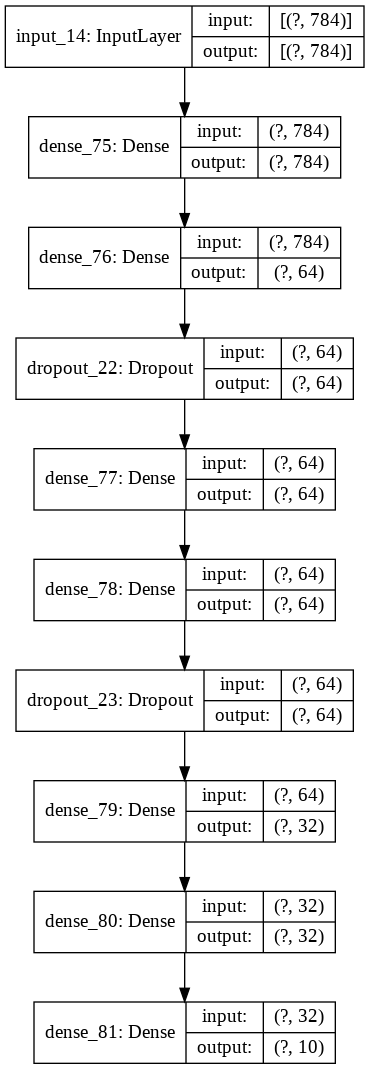

In [0]:
plot_model(model_na, show_shapes=True, expand_nested=True)

In [0]:
hist_na = model_na.fit(x_train_r, y_train, validation_data=(x_test_r, y_test), epochs=10, batch_size=2048)

Epoch 1/10
30/30 [==============================] - 4s 118ms/step - loss: 1.6269 - accuracy: 0.4640 - val_loss: 0.7423 - val_accuracy: 0.8436
Epoch 2/10
30/30 [==============================] - 3s 113ms/step - loss: 0.6652 - accuracy: 0.8386 - val_loss: 0.3235 - val_accuracy: 0.9273
Epoch 3/10
30/30 [==============================] - 3s 114ms/step - loss: 0.3618 - accuracy: 0.9153 - val_loss: 0.2226 - val_accuracy: 0.9455
Epoch 4/10
30/30 [==============================] - 3s 114ms/step - loss: 0.2540 - accuracy: 0.9399 - val_loss: 0.1719 - val_accuracy: 0.9594
Epoch 5/10
30/30 [==============================] - 3s 115ms/step - loss: 0.1891 - accuracy: 0.9562 - val_loss: 0.1486 - val_accuracy: 0.9640
Epoch 6/10
30/30 [==============================] - 3s 115ms/step - loss: 0.1549 - accuracy: 0.9639 - val_loss: 0.1309 - val_accuracy: 0.9664
Epoch 7/10
30/30 [==============================] - 3s 114ms/step - loss: 0.1270 - accuracy: 0.9703 - val_loss: 0.1169 - val_accuracy: 0.9707
Epoch 

Test loss: 0.09930917620658875
Test accuracy: 0.974399983882904
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


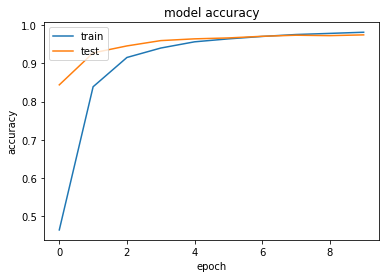

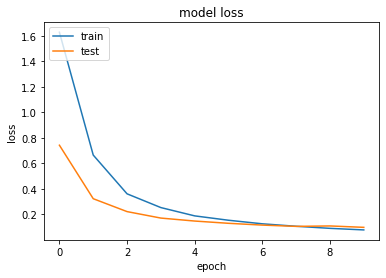

In [0]:
score = model_na.evaluate(x_test_r, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plot_hist(hist_na)

Observed marginal improvement. Maybe replacing all layers with 'tanh' or 'sigmoid' activation can work